In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional
from tensorflow.keras.models import Sequential

In [2]:
os.listdir('../data/stocknews/')

['RedditNews.csv', 'Combined_News_DJIA.csv', 'upload_DJIA_table.csv']

In [3]:
df_reddit = pd.read_csv('../data/stocknews/RedditNews.csv')
df_news = pd.read_csv('../data/stocknews/Combined_News_DJIA.csv')
df_djia = pd.read_csv('../data/stocknews/upload_DJIA_table.csv')


In [4]:
df_djia_news = pd.merge(df_djia, df_news, on='Date', how='inner')

df = pd.merge(df_djia_news, df_reddit, on='Date', how='inner')

In [5]:
df_djia_news['Top1'][0]

'A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898.'

# Sentiment Analysis

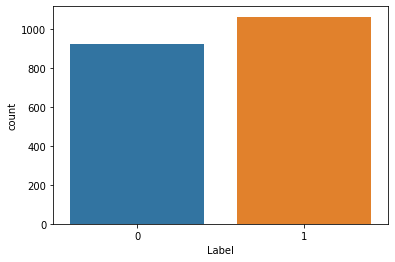

In [6]:
# 0 = decrease , 1 = increase or equal at Adj.Close
sns.countplot(x='Label', data=df_news)

In [7]:
# Preprocess 
def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('',text)

In [8]:
df_news['Top1'][0]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"'

In [9]:
X = list()
sentences = df_news['Top1']
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = df_news['Label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [12]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [13]:
embeddings_dict = dict()

In [14]:
# !touch glove.txt

In [15]:
os.listdir('/Users/2two2/Downloads/glove.6B/')

['glove.6B.300d.txt',
 'glove.6B.100d.txt',
 'glove.6B.50d.txt',
 'glove.6B.200d.txt']

In [16]:
glove_file = open('/Users/2two2/Downloads/glove.6B/glove.6B.300d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector_dimensions
glove_file.close()


In [17]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Simple NN

In [18]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

W1125 13:29:43.414553 4634914240 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow_core/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1125 13:29:43.436879 4634914240 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W1125 13:29:43.599750 4634914240 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and w

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          1997700   
_________________________________________________________________
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 30001     
Total params: 2,027,701
Trainable params: 30,001
Non-trainable params: 1,997,700
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Train on 1272 samples, validate on 319 samples
Epoch 1/20
1272/1272 [==============================] - 0s 276us/sample - loss: 0.7012 - acc: 0.5063 - val_loss: 0.7091 - val_acc: 0.4922
Epoch 2/20
1272/1272 [==============================] - 0s 106us/sample - loss: 0.5936 - acc: 0.7068 - val_loss: 0.7074 - val_acc: 0.4828
Epoch 3/20
1272/1272 [==============================] - 0s 81us/sample - loss: 0.5270 - acc: 0.8184 - val_loss: 0.7121 - val_acc: 0.4859
Epoch 4/20
1272/1272 [==============================] - 0s 113us/sample - loss: 0.4779 - acc: 0.8703 - val_loss: 0.7186 - val_acc: 0.4890
Epoch 5/20
1272/1272 [==============================] - 0s 90us/sample - loss: 0.4380 - acc: 0.8923 - val_loss: 0.7271 - val_acc: 0.4890
Epoch 6/20
1272/1272 [==============================] - 0s 104us/sample - loss: 0.4055 - acc: 0.9159 - val_loss: 0.7354 - val_acc: 0.4953
Epoch 7/20
1272/1272 [==============================] - 0s 70us/sample - loss: 0.3772 - acc: 0.9222 - val_loss: 0.7431 - val_ac

398/398 [==============================] - 1s 3ms/sample - loss: 2.2888 - acc: 0.4673
Test Score: 2.2887789813717405
Test Accuracy: 0.46733668


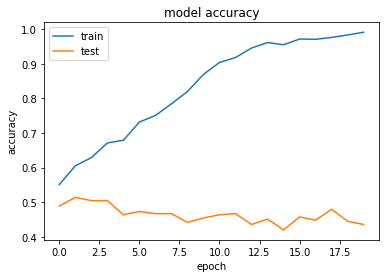

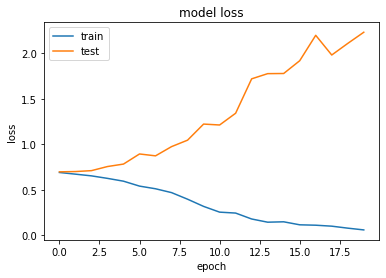

In [22]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Conv1D 

In [95]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 300)          1997700   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,189,957
Trainable params: 192,257
Non-trainable params: 1,997,700
_________________________________________________________________
None


Train on 1272 samples, validate on 319 samples
Epoch 1/6
1272/1272 [==============================] - 2s 1ms/sample - loss: 0.7936 - acc: 0.4984 - val_loss: 0.7248 - val_acc: 0.4859
Epoch 2/6
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.5578 - acc: 0.7406 - val_loss: 0.7218 - val_acc: 0.4765
Epoch 3/6
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.4603 - acc: 0.8766 - val_loss: 0.7729 - val_acc: 0.5423
Epoch 4/6
1272/1272 [==============================] - 1s 974us/sample - loss: 0.3764 - acc: 0.9544 - val_loss: 0.7314 - val_acc: 0.4859
Epoch 5/6
1272/1272 [==============================] - 1s 1ms/sample - loss: 0.3150 - acc: 0.9874 - val_loss: 0.7391 - val_acc: 0.4922
Epoch 6/6
398/398 [==============================] - 0s 494us/sample - loss: 0.7422 - acc: 0.4925
Test Score: 0.742242939508141
Test Accuracy: 0.4924623


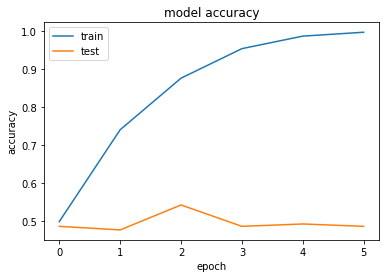

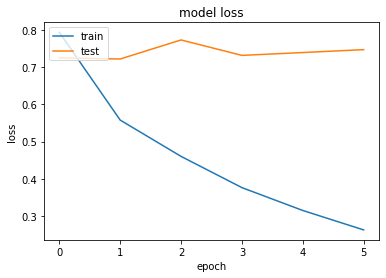

In [96]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

LSTM 

In [20]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

W1125 13:29:46.774669 4634914240 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1125 13:29:46.775897 4634914240 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1125 13:29:46.777451 4634914240 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is de

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          1997700   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,437,253
Trainable params: 439,553
Non-trainable params: 1,997,700
_________________________________________________________________
None


Train on 1272 samples, validate on 319 samples
Epoch 1/20
1272/1272 [==============================] - 12s 9ms/sample - loss: 0.6892 - acc: 0.5511 - val_loss: 0.6962 - val_acc: 0.4890
Epoch 2/20
1272/1272 [==============================] - 9s 7ms/sample - loss: 0.6707 - acc: 0.6053 - val_loss: 0.6994 - val_acc: 0.5141
Epoch 3/20
1272/1272 [==============================] - 9s 7ms/sample - loss: 0.6520 - acc: 0.6289 - val_loss: 0.7094 - val_acc: 0.5047
Epoch 4/20
1272/1272 [==============================] - 9s 7ms/sample - loss: 0.6244 - acc: 0.6714 - val_loss: 0.7546 - val_acc: 0.5047
Epoch 5/20
1272/1272 [==============================] - 11s 8ms/sample - loss: 0.5933 - acc: 0.6792 - val_loss: 0.7817 - val_acc: 0.4639
Epoch 6/20
1272/1272 [==============================] - 11s 9ms/sample - loss: 0.5392 - acc: 0.7319 - val_loss: 0.8930 - val_acc: 0.4734
Epoch 7/20
1272/1272 [==============================] - 17s 13ms/sample - loss: 0.5099 - acc: 0.7508 - val_loss: 0.8723 - val_acc: 0.4

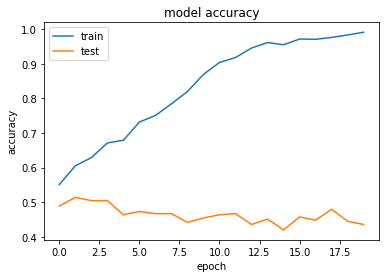

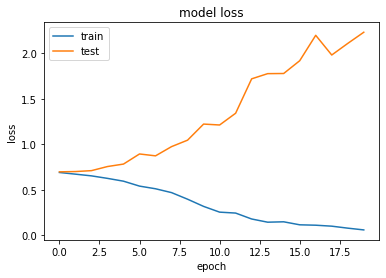

In [21]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Prediction

In [105]:
instance = X[57]
instance = tokenizer.texts_to_sequences(instance)

flat_list = list()
for sublist in instance:
    for item in sublist:
        flat_list.append(item)
        
flat_list = [flat_list]
instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.59076244]], dtype=float32)

In [ ]:
X[547]